# Forecasting Global Video Game Sales

# Data Preprocessing

In [1]:
import pandas as pd;
import numpy as np;
import seaborn as sb
from matplotlib import pyplot as plt
from matplotlib import style
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv('videogame.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


In [3]:
data = data.rename(columns={"Year_of_Release": "Year", 
                            "NA_Sales": "NA",
                            "EU_Sales": "EU",
                            "JP_Sales": "JP",
                            "Other_Sales": "Other",
                            "Global_Sales": "Global"})
data = data[data["Year"].notnull()]
data = data[data["Genre"].notnull()]
data["Year"] = data["Year"].apply(int)
data["User_Score"] = data["User_Score"].replace("tbd", np.nan).astype(float)
data.describe(include="all")

,Name,Platform,Year,Genre,Publisher,NA,EU,JP,Other,Global,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
count,16448,16448,16448.000000,16448,16416,16448.000000,16448.000000,16448.000000,16448.000000,16448.00000,7983.000000,7983.000000,7463.000000,7463.000000,9907,9769
unique,11429,31,NaN,12,579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1680,8
top,Need for Speed: Most Wanted,PS2,NaN,Action,Electronic Arts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ubisoft,E
freq,12,2127,NaN,3308,1344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201,3922
mean,NaN,NaN,2006.488996,NaN,NaN,0.263965,0.145895,0.078472,0.047583,0.53617,68.994363,26.441313,7.126330,163.015141,NaN,NaN
std,NaN,NaN,5.877470,NaN,NaN,0.818286,0.506660,0.311064,0.187984,1.55846,13.920060,19.008136,1.499447,563.863327,NaN,NaN
min,NaN,NaN,1980.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.01000,13.000000,3.000000,0.000000,4.000000,NaN,NaN
25%,NaN,NaN,2003.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.06000,60.000000,12.000000,6.400000,10.000000,NaN,NaN
50%,NaN,NaN,2007.000000,NaN,NaN,0.080000,0.020000,0.000000,0.010000,0.17000,71.000000,22.000000,7.500000,24.000000,NaN,NaN
75%,NaN,NaN,2010.000000,NaN,NaN,0.240000,0.110000,0.040000,0.030000,0.47000,79.000000,36.000000,8.200000,81.000000,NaN,NaN


## Data Cleaning

### Handling Missing Values

We are filling scores and counts with zeros, because there were no real zero scores or counts in the dataset, so it will indicate absence of scores. 

In [4]:
data["Critic_Score"].fillna(0.0, inplace=True)
data["Critic_Count"].fillna(0.0, inplace=True)
data["User_Score"].fillna(0.0, inplace=True)
data["User_Count"].fillna(0.0, inplace=True)

### Handling Outliers

In [5]:
def rm_outliers(df, list_of_keys):
    df_out = df
    for key in list_of_keys:
        
        # Calculate first and third quartile
        first_quartile = df_out[key].describe()["25%"]
        third_quartile = df_out[key].describe()["75%"]

        # Interquartile range
        iqr = third_quartile - first_quartile
        removed = df_out[(df_out[key] <= (first_quartile - 3 * iqr)) |
                    (df_out[key] >= (third_quartile + 3 * iqr))] 
        df_out = df_out[(df_out[key] > (first_quartile - 3 * iqr)) &
                    (df_out[key] < (third_quartile + 3 * iqr))]
        
    return df_out, removed

We remove outliers for 'Global' and 'User_Count'

In [6]:
tmp, rmvd_tmp = rm_outliers(data[data["User_Count"] != 0], ["User_Count"])
data.drop(rmvd_tmp.index, axis=0, inplace=True)
data, rmvd_global = rm_outliers(data, ["Global"])
data.describe()

,Year,NA,EU,JP,Other,Global,Critic_Score,Critic_Count,User_Score,User_Count
count,14765.000000,14765.000000,14765.000000,14765.000000,14765.000000,14765.000000,14765.000000,14765.000000,14765.000000,14765.000000
mean,2006.473485,0.134590,0.063504,0.046849,0.021974,0.267203,30.306400,10.390518,2.944646,16.534236
std,5.728498,0.192363,0.115421,0.128329,0.045871,0.311721,34.424504,15.551403,3.613105,39.203913
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000
50%,2007.000000,0.060000,0.020000,0.000000,0.010000,0.140000,0.000000,0.000000,0.000000,0.000000
75%,2010.000000,0.180000,0.070000,0.030000,0.020000,0.360000,67.000000,17.000000,7.000000,14.000000
max,2020.000000,1.450000,1.160000,1.520000,1.130000,1.530000,98.000000,91.000000,9.700000,293.000000


## Exploratory Data Analysis

### Histogram for checking Skewness

In [7]:
numeric_subset = data.select_dtypes("number").drop(columns=["NA", "EU", "JP", "Other", "Year"])

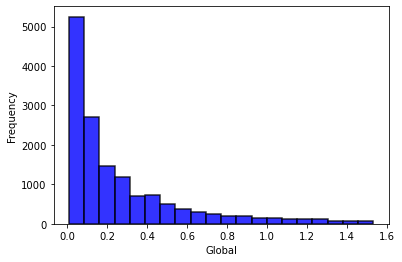

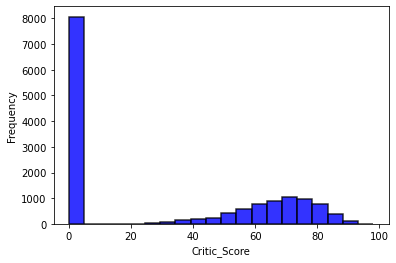

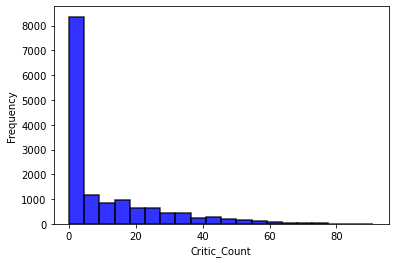

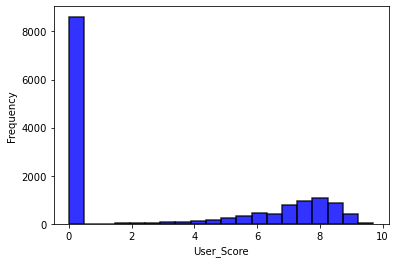

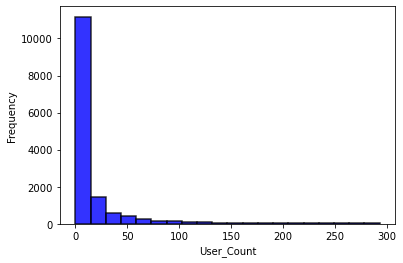

In [8]:
for i in range(numeric_subset.shape[1]):
    plt.figure()
    if type(numeric_subset.iloc[0,i]) != str:
        plt.hist(numeric_subset.iloc[:,i], bins=20, edgecolor='k', facecolor='b', linewidth=1.5, alpha=0.8)
        plt.xlabel(numeric_subset.columns[i])
        plt.ylabel('Frequency')
        plt.show()

### Boxplot of categorical features vs target variable

/Users/kenmai/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kenmai/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


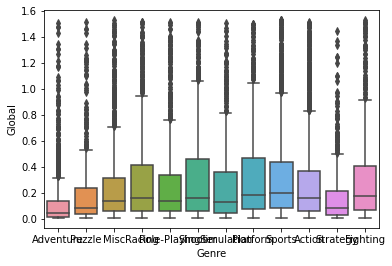

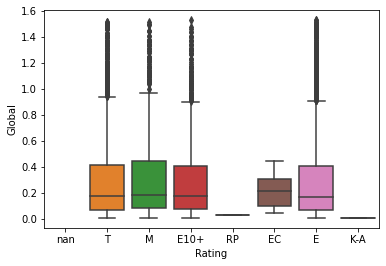

/Users/kenmai/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


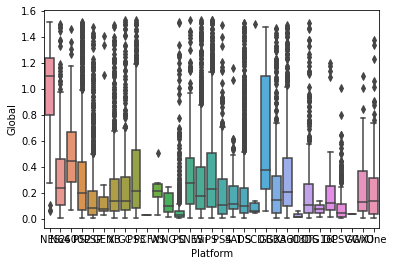

In [9]:
sb.boxplot(data['Genre'], data['Global'], order=list(set(data['Genre'])))
plt.figure()
sb.boxplot(data['Rating'], data['Global'], order=list(set(data['Rating'])))
plt.show()
sb.boxplot(data['Platform'], data['Global'], order=list(set(data['Platform'])))
plt.show()

### The distribution of  the target variable ‘Global’

/Users/kenmai/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.2672028445648734, 0.14)

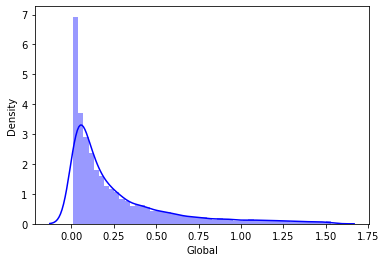

In [10]:
sb.distplot(data["Global"], color='b')
np.mean(data["Global"]), np.median(data["Global"])

### Feature Creation 

In [11]:
scored = data.dropna(subset=["User_Score", "Critic_Score", "Rating"])
scored, rmvd_user_count = rm_outliers(scored, ["User_Count"])
scored.describe()

,Year,NA,EU,JP,Other,Global,Critic_Score,Critic_Count,User_Score,User_Count
count,7950.000000,7950.000000,7950.000000,7950.000000,7950.000000,7950.000000,7950.000000,7950.000000,7950.000000,7950.000000
mean,2007.233585,0.166401,0.073750,0.017847,0.028146,0.286434,50.929057,16.559497,4.937862,18.298742
std,3.904239,0.187728,0.117981,0.073832,0.051457,0.305900,30.057629,15.492856,3.460594,24.364081
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000
25%,2004.000000,0.040000,0.000000,0.000000,0.000000,0.070000,37.000000,4.000000,0.000000,0.000000
50%,2007.000000,0.100000,0.030000,0.000000,0.010000,0.170000,62.000000,13.000000,6.500000,9.000000
75%,2010.000000,0.220000,0.090000,0.000000,0.030000,0.390000,73.000000,26.000000,7.800000,24.000000
max,2020.000000,1.260000,1.140000,1.390000,1.130000,1.530000,97.000000,84.000000,9.700000,119.000000


In [12]:
data["Age"] = 2018 - data["Year"]

In [13]:
# Making a new column which shows if the game is scored or not. (User score and Critic Score)

data["Has_Score"] = data["User_Score"].notnull() & data["Critic_Score"].notnull()


In [14]:
import category_encoders as ce

In [15]:
#Number of unique platforms present 
data["Platform"].unique()

array(['Wii', 'PS3', 'SNES', 'PS', 'GC', 'PS2', 'NES', 'PC', 'DS', '3DS',
       'N64', 'SCD', 'XB', 'X360', 'PS4', 'GB', 'PSP', 'GBA', '2600',
       'GEN', 'XOne', 'DC', 'SAT', 'WiiU', 'PSV', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

There are too many different platforms and most of them represent a very small percent of games. I am going to group platforms to reduce the number of features.

In [16]:
#Grouping platforms together
platforms = {"Playstation" : ["PS", "PS2", "PS3", "PS4"],
             "Xbox" : ["XB", "X360", "XOne"], 
             "PC" : ["PC"],
             "Nintendo" : ["Wii", "WiiU"],
             "Portable" : ["GB", "GBA", "GC", "DS", "3DS", "PSP", "PSV"]}

Below are the functions that I am going to use to plot the data and get inferences as well help to group the platforms as required.

In [17]:
def visual_chart(column, palette="Set2"):
    values = column.value_counts().values
    labels = column.value_counts().index
    plt.pie(values, colors=sb.color_palette(palette), 
            labels=labels, autopct="%1.1f%%", 
            startangle=90, pctdistance=0.85)
    
    #draw circle
    centre_circle = plt.Circle((0,0), 0.70, fc="white")
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

In [18]:
def get_group_label(x, groups=None):
    if groups is None:
        return "Other"
    else:
        for key, val in groups.items():
            if x in val:
                return key
        return "Other"

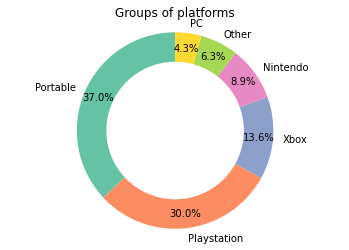

In [19]:
data["Grouped_Platform"] = data["Platform"].apply(lambda x: get_group_label(x, groups=platforms))
visual_chart(data["Grouped_Platform"])
plt.title("Groups of platforms")
plt.axis("equal");

Looks much better.

Now I want to check the same thing for genres.

(-1.111677767399533,
 1.1028093069102034,
 -1.102842546942564,
 1.1001353593782173)

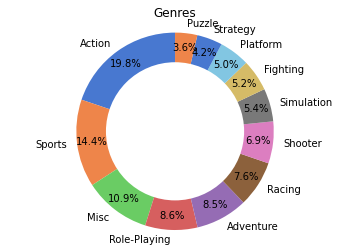

In [20]:
visual_chart(data["Genre"], palette="muted")
plt.title("Genres")
plt.axis("equal")

The distribution seems ok, even though there is a significant number of different genres.

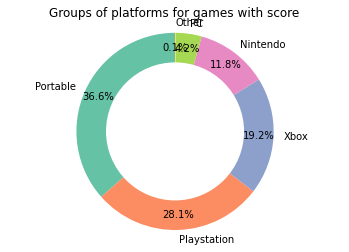

In [21]:
#Grouping the platforms for the entries whose score is given
scored["Grouped_Platform"] = scored["Platform"].apply(lambda x: get_group_label(x, platforms))
visual_chart(scored["Grouped_Platform"])
plt.title("Groups of platforms for games with score")
plt.axis("equal");

Almost all games that have scores are for "big" platfroms: PC, PS, Xbox or portable. But there are few from the "Other" group. Below are the results what the "Other" platform represents. (DC - Dreamcast)

In [22]:
scored[scored["Grouped_Platform"]=="Other"]

,Name,Platform,Year,Genre,Publisher,NA,EU,JP,Other,Global,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Grouped_Platform
1877,NFL 2K1,DC,2000,Sports,Sega,1.02,0.05,0.00,0.02,1.09,97.0,22.0,6.0,47.0,Visual Concepts,E,Other
3815,Seaman,DC,1999,Simulation,Sega,0.00,0.00,0.52,0.00,0.52,82.0,24.0,8.4,16.0,Vivarium,T,Other
7231,Capcom vs. SNK,DC,2000,Fighting,Virgin Interactive,0.00,0.00,0.22,0.00,0.22,80.0,17.0,9.0,24.0,Capcom,T,Other
7521,Phantasy Star Online,DC,2000,Role-Playing,Sega,0.00,0.00,0.20,0.00,0.20,89.0,21.0,9.1,33.0,Sonic Team,T,Other
7643,Grandia II,DC,2000,Role-Playing,Ubisoft,0.00,0.00,0.20,0.00,0.20,90.0,17.0,8.8,57.0,Game Arts,T,Other
7978,Phantasy Star Online Ver. 2,DC,2001,Role-Playing,Sega,0.00,0.00,0.19,0.00,0.19,80.0,10.0,8.9,18.0,Sonic Team,T,Other
9559,Sega GT,DC,2000,Racing,Sega,0.00,0.00,0.13,0.00,0.13,84.0,25.0,7.7,11.0,TOSE,E,Other
10999,Skies of Arcadia,DC,2000,Role-Playing,Sega,0.00,0.00,0.09,0.00,0.09,93.0,21.0,9.4,98.0,Overworks,T,Other
12096,Crazy Taxi 2,DC,2001,Racing,Sega,0.00,0.00,0.07,0.00,0.07,82.0,18.0,8.1,29.0,Hitmaker,T,Other
13110,The Typing of the Dead,DC,2000,Shooter,Sega,0.00,0.00,0.05,0.00,0.05,83.0,12.0,7.8,12.0,Smilebit,M,Other


Next I want to create some new features: weighted score and my own developer rating. First, I find percent of all games created by each developer, then calculate cumulative percent starting with devs with the least number of games. Finally, I divide them into 10 groups (10% each). Higher rank means more games developed. 

Higher top percentage means more games developed.

In [23]:
# One weighted score value including all scores and counts field.
scored["Weighted_Score"] = (scored["User_Score"] * 10 * scored["User_Count"] + 
                            scored["Critic_Score"] * scored["Critic_Count"]) / (scored["User_Count"] + scored["Critic_Count"])

# Dataframe having developers arranged based on their frequency 
devs = pd.DataFrame({"dev": scored["Developer"].value_counts().index,
                     "count": scored["Developer"].value_counts().values})

# Mean scoring datafram based on the weighted score
m_score = pd.DataFrame({"dev": scored.groupby("Developer")["Weighted_Score"].mean().index,
                        "mean_score": scored.groupby("Developer")["Weighted_Score"].mean().values})

# Creating merging the mean_score and developer dataframes and then sorting the resultant into ascending order
devs = pd.merge(devs, m_score, on="dev")
devs = devs.sort_values(by="count", ascending=True)

# Percentage of all games created by each developer and storing it in form of cumulative fashion
devs["percent"] = devs["count"] / devs["count"].sum()
devs["top%"] = devs["percent"].cumsum() * 100

# Dividing them into 10 groups
n_groups = 10
devs["top_group"] = (devs["top%"] * n_groups) // 100 + 1
devs["top_group"].iloc[-1] = n_groups
devs

/Users/kenmai/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,dev,count,mean_score,percent,top%,top_group
1504,Metro3D,1,54.071429,0.000126,0.012579,1.0
1105,Zushi Games Ltd,1,NaN,0.000126,0.025157,1.0
1104,Pterodon,1,84.081633,0.000126,0.037736,1.0
1103,Phenomedia,1,39.000000,0.000126,0.050314,1.0
1102,Aqua Pacific,1,60.000000,0.000126,0.062893,1.0
...,...,...,...,...,...,...
4,Capcom,93,74.056409,0.011698,92.981132,10.0
3,EA Sports,124,72.301346,0.015597,94.540881,10.0
2,Konami,127,68.519963,0.015975,96.138365,10.0
1,EA Canada,134,72.505312,0.016855,97.823899,10.0


We also have to fill in missing values for 'Developer Rank' and 'Rating' with 0.

In [24]:
data = data.join(devs.set_index("dev")["top_group"], on="Developer")
data = data.rename(columns={"top_group": "Developer_Rank"})
data["Developer_Rank"].fillna(0.0, inplace=True)
data["Rating"].fillna("None", inplace=True)

In [25]:
data["Weighted_Score"] = (data["User_Score"] * 10 * data["User_Count"] + 
                            data["Critic_Score"] * data["Critic_Count"]) / (data["User_Count"] + data["Critic_Count"])
data["Weighted_Score"].fillna(0.0, inplace=True)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14765 entries, 1220 to 16718
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              14765 non-null  object 
 1   Platform          14765 non-null  object 
 2   Year              14765 non-null  int64  
 3   Genre             14765 non-null  object 
 4   Publisher         14734 non-null  object 
 5   NA                14765 non-null  float64
 6   EU                14765 non-null  float64
 7   JP                14765 non-null  float64
 8   Other             14765 non-null  float64
 9   Global            14765 non-null  float64
 10  Critic_Score      14765 non-null  float64
 11  Critic_Count      14765 non-null  float64
 12  User_Score        14765 non-null  float64
 13  User_Count        14765 non-null  float64
 14  Developer         8585 non-null   object 
 15  Rating            14765 non-null  object 
 16  Age               14765 non-null  int

In [27]:
# Select the numeric columns
numeric_subset = data.select_dtypes("number").drop(columns=["NA", "EU", "JP", "Other", "Year"])

# Select the categorical columns
categorical_subset = data[["Grouped_Platform", "Genre", "Rating"]]

mapping = []
for cat in categorical_subset.columns:
    tmp = scored.groupby(cat).median()["Weighted_Score"]
    mapping.append({"col": cat, "mapping": [x for x in np.argsort(tmp).items()]})
    
encoder = ce.ordinal.OrdinalEncoder()
categorical_subset = encoder.fit_transform(categorical_subset, mapping=mapping)

# Join the two dataframes using concat. Axis = 1 -> Column bind
data = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Find correlations with the score 
correlations = data.corr()["Global"].dropna().sort_values()

In [28]:
data

,Global,Critic_Score,Critic_Count,User_Score,User_Count,Age,Developer_Rank,Weighted_Score,Grouped_Platform,Genre,Rating
1220,1.53,64.0,28.0,7.8,13.0,7,5.0,68.439024,1,1,1
1221,1.53,82.0,37.0,6.7,146.0,6,10.0,70.032787,2,2,2
1222,1.53,0.0,0.0,0.0,0.0,24,0.0,0.000000,3,3,3
1223,1.53,0.0,0.0,0.0,0.0,20,0.0,0.000000,2,2,3
1225,1.53,81.0,49.0,8.0,56.0,15,4.0,80.466667,4,2,2
...,...,...,...,...,...,...,...,...,...,...,...
16714,0.01,0.0,0.0,0.0,0.0,2,0.0,0.000000,2,4,3
16715,0.01,0.0,0.0,0.0,0.0,12,0.0,0.000000,6,2,3
16716,0.01,0.0,0.0,0.0,0.0,2,0.0,0.000000,4,9,3
16717,0.01,0.0,0.0,0.0,0.0,15,0.0,0.000000,4,11,3


In [29]:
correlations

Grouped_Platform   -0.104512
Genre              -0.074722
Rating              0.012593
Developer_Rank      0.173932
Age                 0.179655
Weighted_Score      0.212958
Critic_Score        0.219344
User_Score          0.235349
User_Count          0.252620
Critic_Count        0.288875
Global              1.000000
Name: Global, dtype: float64

Observation:

## Train-Test Spliting and Feature Scaling:

In [30]:
from sklearn.model_selection import train_test_split
target = pd.Series(data["Global"])
features = data.drop(columns="Global",axis = 1)
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.4,
                                                                            stratify=data['Global'],
                                                                            random_state=88)

In [31]:
features_train

,Critic_Score,Critic_Count,User_Score,User_Count,Age,Developer_Rank,Weighted_Score,Grouped_Platform,Genre,Rating
4349,56.0,48.0,6.9,47.0,13,2.0,62.431579,6,3,5
9466,0.0,0.0,7.2,19.0,2,10.0,72.000000,2,2,2
6371,0.0,0.0,0.0,0.0,19,0.0,0.000000,2,7,3
16682,0.0,0.0,0.0,0.0,6,2.0,0.000000,5,12,5
2074,87.0,43.0,8.4,238.0,7,1.0,84.459075,2,11,1
...,...,...,...,...,...,...,...,...,...,...
8825,62.0,39.0,6.0,34.0,13,10.0,61.068493,6,2,2
8082,0.0,0.0,0.0,0.0,22,0.0,0.000000,2,1,3
2511,0.0,0.0,0.0,0.0,34,0.0,0.000000,3,8,3
15817,0.0,0.0,0.0,0.0,12,6.0,0.000000,2,1,2


In [127]:
features_train.shape

(8859, 10)

In [32]:
features_test

,Critic_Score,Critic_Count,User_Score,User_Count,Age,Developer_Rank,Weighted_Score,Grouped_Platform,Genre,Rating
9703,0.0,0.0,0.0,0.0,12,0.0,0.000000,2,7,3
8855,0.0,0.0,0.0,0.0,10,0.0,0.000000,1,8,3
4292,0.0,0.0,0.0,0.0,10,5.0,0.000000,4,9,2
15958,0.0,0.0,0.0,0.0,11,0.0,0.000000,4,12,3
1836,74.0,38.0,7.6,51.0,15,2.0,75.146067,6,6,4
...,...,...,...,...,...,...,...,...,...,...
4997,60.0,7.0,5.1,7.0,13,8.0,55.500000,2,1,2
15284,0.0,0.0,0.0,0.0,16,0.0,0.000000,2,9,3
14787,78.0,33.0,7.8,13.0,15,3.0,78.000000,4,6,4
16574,0.0,0.0,0.0,0.0,5,0.0,0.000000,4,7,3


In [128]:
features_test.shape

(5906, 10)

In [129]:
target_train.shape

(8859,)

In [130]:
target_test.shape

(5906,)

### Feature Scaling

We would apply feature scaling to our dataset for model building except for linear models.

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.fit_transform(features_test)

In [34]:
features_train_scaled

array([[ 7.56168380e-01,  2.43051543e+00,  1.10908635e+00, ...,
         1.73167485e+00, -7.33782629e-01,  1.72546482e+00],
       [-8.73322615e-01, -6.63848241e-01,  1.19241716e+00, ...,
        -9.28675015e-01, -1.04158983e+00, -8.62878495e-01],
       [-8.73322615e-01, -6.63848241e-01, -8.07522098e-01, ...,
        -9.28675015e-01,  4.97446181e-01, -9.73903493e-05],
       ...,
       [-8.73322615e-01, -6.63848241e-01, -8.07522098e-01, ...,
        -2.63587549e-01,  8.05253384e-01, -9.73903493e-05],
       [-8.73322615e-01, -6.63848241e-01, -8.07522098e-01, ...,
        -9.28675015e-01, -1.34939703e+00, -8.62878495e-01],
       [ 1.36722750e+00,  8.18867687e-01,  1.08130942e+00, ...,
        -9.28675015e-01,  1.89638979e-01,  8.62683714e-01]])

In [35]:
features_test_scaled

array([[-0.89110442, -0.67464718, -0.82634671, ..., -0.90393327,
         0.49782551, -0.01618957],
       [-0.89110442, -0.67464718, -0.82634671, ..., -1.56563752,
         0.80425151, -0.01618957],
       [-0.89110442, -0.67464718, -0.82634671, ...,  0.41947523,
         1.1106775 , -0.86234537],
       ...,
       [ 1.36952564,  1.43967185,  1.32153648, ...,  0.41947523,
         0.19139951,  0.82996623],
       [-0.89110442, -0.67464718, -0.82634671, ...,  0.41947523,
         0.49782551, -0.01618957],
       [ 1.07970128,  1.05525021,  1.59690613, ..., -0.90393327,
        -0.42145249,  0.82996623]])

# Model Fitting and Evaluation:

Evaluation Metrics:

In [36]:
def OSR2(y_pred, y_test, y_train):   
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)    
    return 1 - SSE/SST



# we add y_train here so that our bootstrap function is more general
def MAE(y_pred, y_test, y_train=None):   
    MAE = np.sum(abs(y_test - y_pred))/len(y_test)
    return MAE

In [37]:
def OSR2_Model(model, X_test, y_test, y_train):
    
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
                 
    return (1 - SSE/SST)
def MAE_Model(model, X_test, y_test, y_train=None): 
    y_pred = model.predict(X_test)
    MAE = np.sum(abs(y_test - y_pred))/len(y_test)
    return MAE

## Ordinary Least Squares(i.e multiple linear regression)

In [238]:
X_train, X_test, y_train, y_test = features_train, features_test,target_train, target_test

In [239]:
import statsmodels.api as sm

In [240]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
model0 = sm.OLS(y_train, X_train).fit()

print(model0.summary())

                            OLS Regression Results                            
Dep. Variable:                 Global   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     203.1
Date:                Sun, 27 Nov 2022   Prob (F-statistic):               0.00
Time:                        16:08:29   Log-Likelihood:                -1324.1
No. Observations:                8859   AIC:                             2670.
Df Residuals:                    8848   BIC:                             2748.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2082      0.014  

In [241]:
OSR2_Model(model0, X_test, y_test, y_train)

0.18499627014990994

In [242]:
MAE_Model(model0, X_test, y_test,y_train)

0.19953655319617652

In [243]:
## Writing a function to calculate the VIF.
from statsmodels.stats.outliers_influence import variance_inflation_factor
def VIF(df, columns):
    
    values = sm.add_constant(df[columns]).values  # the dataframe passed to VIF must include the intercept term. We add it the same way we did before.
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    
    return pd.Series(vif[1:], index=columns)

In [244]:
cols0 = ['Critic_Score', 'Critic_Count', 'User_Score', 'User_Count',
      'Age', 'Developer_Rank', 'Weighted_Score', 'Grouped_Platform', 'Genre',
      'Rating']
VIF(X_train, cols0)

Critic_Score         9.713764
Critic_Count         3.329170
User_Score           5.538787
User_Count           1.739342
Age                  1.094327
Developer_Rank       1.810416
Weighted_Score      14.273106
Grouped_Platform     1.059041
Genre                1.033485
Rating               1.132998
dtype: float64

In [245]:
X_train = X_train.drop(['Weighted_Score'],axis = 1)

In [246]:
X_test = X_test.drop(['Weighted_Score'],axis = 1)

In [247]:
X_test = sm.add_constant(X_test)

Final MLR Model:

In [248]:
model1 = sm.OLS(y_train, X_train).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                 Global   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     224.7
Date:                Sun, 27 Nov 2022   Prob (F-statistic):               0.00
Time:                        16:08:41   Log-Likelihood:                -1327.9
No. Observations:                8859   AIC:                             2676.
Df Residuals:                    8849   BIC:                             2747.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2072      0.014  

In [249]:
cols1 = ['Critic_Score', 'Critic_Count', 'User_Score', 'User_Count',
       'Age', 'Developer_Rank','Grouped_Platform', 'Genre',
       'Rating']

VIF(X_train, cols1)

Critic_Score        4.210045
Critic_Count        3.265231
User_Score          3.227572
User_Count          1.738405
Age                 1.094097
Developer_Rank      1.741893
Grouped_Platform    1.057116
Genre               1.033485
Rating              1.132994
dtype: float64

In [250]:
OSR2_Model(model1, X_test, y_test, y_train)

0.1847502922969949

In [251]:
MAE_Model(model1, X_test, y_test, y_train)

0.19971274365471622

## Polynomial Regression

In [52]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score 

In [53]:
poly2_features = PolynomialFeatures(degree =2,include_bias=True)
features_train_poly2 = poly2_features.fit_transform(features_train)
polynomial_regressor = LinearRegression()
polynomial_regressor.fit(features_train_poly2, target_train)
features_test_poly2 = poly2_features.transform(features_test)
Y_pred = polynomial_regressor.predict(features_test_poly2)

In [54]:
OSR2(Y_pred,target_test,target_train)

0.2397246190377531

In [55]:
MAE(Y_pred, target_test)

0.1900096985564308

In [56]:
poly3_features = PolynomialFeatures(degree =3,include_bias=True)
features_train_poly3 = poly3_features.fit_transform(features_train)
polynomial_regressor = LinearRegression()
polynomial_regressor.fit(features_train_poly3, target_train)
features_test_poly3 = poly3_features.transform(features_test)
Y_pred = polynomial_regressor.predict(features_test_poly3)

In [57]:
OSR2(Y_pred,target_test,target_train)

0.232959712307641

In [58]:
MAE(Y_pred, target_test)

0.189357402284772

In [59]:
poly4_features = PolynomialFeatures(degree =4,include_bias=True)
features_train_poly4 = poly4_features.fit_transform(features_train)
polynomial_regressor = LinearRegression()
polynomial_regressor.fit(features_train_poly4, target_train)
features_test_poly4 = poly4_features.transform(features_test)
Y_pred = polynomial_regressor.predict(features_test_poly4)

In [60]:
OSR2(Y_pred,target_test,target_train)

0.003669610904592835

In [61]:
MAE(Y_pred, target_test)

0.20163977036190014

In [62]:
poly5_features = PolynomialFeatures(degree =5,include_bias=True)
features_train_poly5 = poly5_features.fit_transform(features_train)
polynomial_regressor = LinearRegression()
polynomial_regressor.fit(features_train_poly5, target_train)
features_test_poly5 = poly5_features.transform(features_test)
Y_pred = polynomial_regressor.predict(features_test_poly5)

In [63]:
OSR2(Y_pred,target_test,target_train)

-128.30326169191082

In [64]:
MAE(Y_pred, target_test)

0.48836948467254093

The performance become worse as degree increase, we choose degree of 2 as our final polynomial regression model.

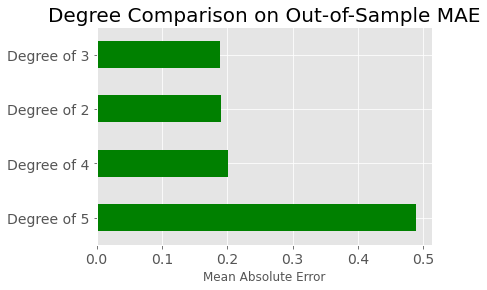

In [262]:
style.use('ggplot')
model_comparison = pd.DataFrame({"degree": ["Degree of 2", "Degree of 3","Degree of 4", "Degree of 5"],
                                "mae": [0.1900096985564308,0.189357402284772,0.20163977036190014,0.48836948467254093]})

model_comparison.sort_values("mae", ascending=False).plot(x="degree", y="mae", kind="barh",
                                                           color="green", legend=False)
plt.ylabel(""); plt.yticks(size=14); plt.xlabel("Mean Absolute Error"); plt.xticks(size=14)
plt.title("Degree Comparison on Out-of-Sample MAE", size=20);

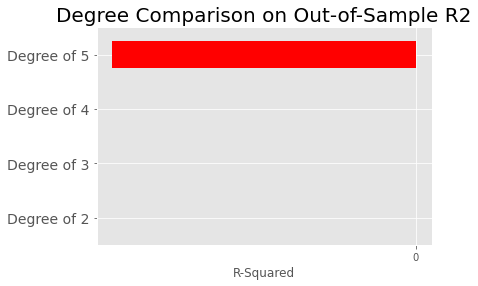

In [269]:
style.use('ggplot')
model_comparison = pd.DataFrame({"degree": ["Degree of 2", "Degree of 3","Degree of 4", "Degree of 5"],
                                "r2": [0.2397246190377531,0.232959712307641,0.003669610904592835,-128.30326169191082]})

model_comparison.sort_values("r2", ascending=False).plot(x="degree", y="r2", kind="barh",
                                                           color="red", legend=False)
x = x = np.arange(0,1)
plt.ylabel(""); plt.yticks(size=14); plt.xlabel("R-Squared"); plt.xticks(x)
plt.title("Degree Comparison on Out-of-Sample R2", size=20);

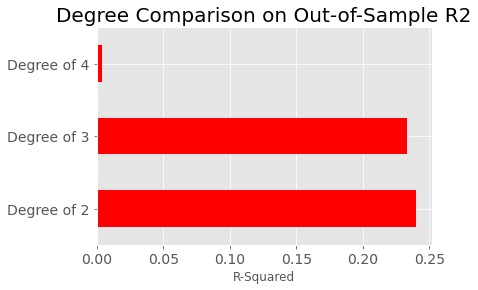

In [271]:
style.use('ggplot')
model_comparison = pd.DataFrame({"degree": ["Degree of 2", "Degree of 3","Degree of 4"],
                                "r2": [0.2397246190377531,0.232959712307641,0.003669610904592835]})

model_comparison.sort_values("r2", ascending=False).plot(x="degree", y="r2", kind="barh",
                                                           color="red", legend=False)

plt.ylabel(""); plt.yticks(size=14); plt.xlabel("R-Squared"); plt.xticks(size=14)
plt.title("Degree Comparison on Out-of-Sample R2", size=20);

## Decision Tree

In [65]:
from sklearn.tree import DecisionTreeRegressor

baseline model:

In [66]:
dt0 = DecisionTreeRegressor()

In [67]:
dt0.fit(features_train_scaled,target_train)
Y_pred = dt0.predict(features_test_scaled)

In [68]:
OSR2(Y_pred,target_test,target_train)

-0.21135769902683332

In [69]:
MAE(Y_pred, target_test)

0.22339592504651698

In [70]:
param_test1 = {"max_depth" : [1,3,5,7,9,11,12],
              "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "max_leaf_nodes":[10,20,30,40,50,60,70,80,90],
           "max_features":["auto","log2","sqrt"]}
gsearch1 = GridSearchCV(DecisionTreeRegressor(),param_grid=param_test1,scoring='r2',cv=3)
gsearch1.fit(features_train_scaled,target_train)
gsearch1.best_params_


{'max_depth': 7,
 'max_features': 'auto',
 'max_leaf_nodes': 40,
 'min_samples_leaf': 6}

In [71]:
dt1 = DecisionTreeRegressor(max_depth=7,max_leaf_nodes=40,min_samples_leaf=10,max_features='auto')
dt1.fit(features_train_scaled,target_train)
Y_pred = dt1.predict(features_test_scaled)

In [72]:
OSR2(Y_pred,target_test,target_train)

0.22090727430901247

In [73]:
MAE(Y_pred, target_test)

0.1906672394917888

In [74]:
param_test2 = {'min_samples_split':[20,30,40,50,60,70,80]}
gsearch2 = GridSearchCV(DecisionTreeRegressor(max_depth=7,max_leaf_nodes=40,min_samples_leaf=10,max_features='auto'),
                        param_grid=param_test2,scoring='r2',cv=3)
gsearch2.fit(features_train_scaled,target_train)
gsearch2.best_params_

{'min_samples_split': 70}

Final Decision Tree Model

In [75]:
dt2 = DecisionTreeRegressor(max_depth=7,max_leaf_nodes=40,min_samples_leaf=10,
                            max_features='auto',min_samples_split=70)
dt2.fit(features_train_scaled,target_train)
Y_pred = dt2.predict(features_test_scaled)

In [76]:
OSR2(Y_pred,target_test,target_train)

0.2219212783246397

In [77]:
MAE(Y_pred, target_test)

0.19043137353879616

## Gradient Boosting

There 2 types of parameters here:

Tree-specific parameters

min_samples_split

min_samples_leaf

max_depth

min_leaf_nodes

max_features


Boosting-specific paramters

n_estimators

learning_rate

subsample

Approach for tackling the problem

Decide a relatively higher value for learning rate and tune the number of estimators requried for that.

Tune the tree specific parameters for that learning rate


Lower learning rate as much as possible computationally and increase the number of estimators accordingly.


Step 1- Find the number of estimators for a high learning rate

We will use the following benchmarks for parameters:

min_samples_split = 500 : ~0.5-1% of total values.

We'll take small value min_samples_leaf = 50 : Just using for preventing overfitting. will be tuned later.

max_depth = 8 : since high number of observations and predictors, choose relatively high value

max_features = 'sqrt' : general thumbrule to start with

subsample = 0.8 : typically used value (will be tuned later)

0.1 is assumed to be a good learning rate to start with. Let's try to find the optimum number of estimators requried for this.

Baseline model:

In [78]:
from sklearn.ensemble import GradientBoostingRegressor
gbm0 = GradientBoostingRegressor(random_state=10)
gbm0.fit(features_train_scaled,target_train)
Y_pred = gbm0.predict(features_test_scaled)

In [79]:
OSR2(Y_pred,target_test,target_train)

0.27317528476248265

In [80]:
MAE(Y_pred, target_test)

0.1843553999564441

Step 2- Tune tree-specific parameters

Now, lets move onto tuning the tree parameters. We will do this in 2 stages:

Tune max_depth and num_samples_split
Tune min_samples_leaf
Tune max_features

In [81]:
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=500,
                                  min_samples_leaf=50,max_depth=8,max_features='sqrt',
                                random_state=10), param_grid = param_test1, scoring='r2',cv=5)
gsearch1.fit(features_train_scaled,target_train)
gsearch1.best_params_

{'n_estimators': 80}

In [82]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=80, min_samples_leaf=50, 
      max_features='sqrt', random_state=10), 
   param_grid = param_test2, scoring='r2',cv=5)
gsearch2.fit(features_train_scaled,target_train)
gsearch2.best_params_

{'max_depth': 9, 'min_samples_split': 200}

In [83]:
param_test3 = {'min_samples_split':range(200,1001,200), 'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=80,max_depth=11,
                                     max_features='sqrt',random_state=10), 
                       param_grid = param_test3, scoring='r2',cv=5)
gsearch3.fit(features_train_scaled,target_train)
gsearch3.best_params_

{'min_samples_leaf': 30, 'min_samples_split': 200}

In [84]:
gbm1 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=1000,max_depth=11, min_samples_leaf =30, 
               min_samples_split =200, max_features='sqrt',random_state=10)
gbm1.fit(features_train_scaled,target_train)
Y_pred = gbm1.predict(features_test_scaled)

In [85]:
OSR2(Y_pred,target_test,target_train)

0.2623920233643695

In [86]:
MAE(Y_pred, target_test)

0.183253411808698

In [87]:
#Grid seach on max_features
param_test4 = {'max_features':range(7,20,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=80,max_depth=11, 
                            min_samples_split=200, min_samples_leaf=60, subsample=0.8, random_state=10),
                        param_grid = param_test4, scoring='r2',n_jobs=4,cv=5)
gsearch4.fit(features_train_scaled,target_train)
gsearch4.best_params_

{'max_features': 9}

In [88]:
gbm2 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=80,max_depth=11, min_samples_leaf =30, 
               min_samples_split =200, subsample=0.9,random_state=10)
gbm2.fit(features_train_scaled,target_train)
Y_pred = gbm2.predict(features_test_scaled)

In [89]:
OSR2(Y_pred,target_test,target_train)

0.30118206708256134

In [90]:
MAE(Y_pred, target_test)

0.1777895641998887

Step 3- Lower Learning Rate and More Estimators

With all tuned lets try reducing the learning rate and proportionally increasing the number of estimators to get more robust results.

1/2th learning rate and 2*n_estimators

In [91]:
gbm3 = GradientBoostingRegressor(learning_rate=0.05, n_estimators=160,max_depth=11, min_samples_leaf =30, 
               min_samples_split =200, subsample=0.9,random_state=10)
gbm3.fit(features_train_scaled,target_train)
Y_pred = gbm3.predict(features_test_scaled)

In [92]:
OSR2(Y_pred,target_test,target_train)

0.3060227972950782

In [93]:
MAE(Y_pred, target_test)

0.17757344608799594

1/10th learning rate and 5*n_estimators

In [94]:
gbm4 = GradientBoostingRegressor(learning_rate=0.01, n_estimators=800,max_depth=11, min_samples_leaf =30, 
               min_samples_split =200, subsample=0.9,random_state=10)
gbm4.fit(features_train_scaled,target_train)
Y_pred = gbm4.predict(features_test_scaled)

In [272]:
gbm4

GradientBoostingRegressor(learning_rate=0.01, max_depth=11, min_samples_leaf=30,
                          min_samples_split=200, n_estimators=800,
                          random_state=10, subsample=0.9)

In [95]:
OSR2(Y_pred,target_test,target_train)

0.30778395356180366

In [96]:
MAE(Y_pred, target_test)

0.1771942471559964

1/20 th learning rate and 15*n_estimators

In [97]:
gbm5 = GradientBoostingRegressor(learning_rate=0.005, n_estimators=1200,max_depth=11, min_samples_leaf =30, 
               min_samples_split =200, subsample=0.9,random_state=10)
gbm5.fit(features_train_scaled,target_train)
Y_pred = gbm5.predict(features_test_scaled)

In [98]:
OSR2(Y_pred,target_test,target_train)

0.30642125228437733

In [99]:
MAE(Y_pred, target_test)

0.17767383355365518

Now with too low learning rate and too many estimators, the perfromance get worse. So for gbm, the best one is gbm 4.

## Random Forest

baseline model

In [100]:
from sklearn.ensemble import RandomForestRegressor

In [101]:
rf0 = RandomForestRegressor(oob_score=True, random_state=10)
rf0.fit(features_train_scaled,target_train)
Y_pred = rf0.predict(features_test_scaled)

In [102]:
OSR2(Y_pred,target_test,target_train)

0.2295778589774431

In [103]:
MAE(Y_pred, target_test)

0.18747221277013323

Step 1 : Tune bagging-specific parameters:

In [104]:
param_test1 = {'n_estimators':[10,20,30,40,50,60,70]}
gsearch1 = GridSearchCV(estimator = RandomForestRegressor(min_samples_split=100,
                                  min_samples_leaf=20,max_depth=8,max_features='sqrt' ,random_state=10), 
                       param_grid = param_test1, scoring='r2',cv=5)
gsearch1.fit(features_train_scaled,target_train)
gsearch1.best_params_

{'n_estimators': 50}

Step 2: Tune important tree-specific parameters:

In [105]:
param_test2 = {'max_depth':[3,5,7,9,11,13], 'min_samples_split':[50,70,90,110,130,150,170,190]}
gsearch2 = GridSearchCV(estimator = RandomForestRegressor(n_estimators= 30, 
                                  min_samples_leaf=20,max_features='sqrt' ,oob_score=True, random_state=10),
                                  param_grid = param_test2, scoring='r2',cv=5)
gsearch2.fit(features_train_scaled,target_train)
gsearch2.best_params_

{'max_depth': 13, 'min_samples_split': 50}

In [106]:
rf1 = RandomForestRegressor(n_estimators= 30, max_depth=13, min_samples_split=50,
                                  min_samples_leaf=20,max_features='sqrt' ,oob_score=True, random_state=10)
rf1.fit(features_train_scaled,target_train)


RandomForestRegressor(max_depth=13, max_features='sqrt', min_samples_leaf=20,
                      min_samples_split=50, n_estimators=30, oob_score=True,
                      random_state=10)

In [107]:
Y_pred = rf1.predict(features_test_scaled)

In [108]:
OSR2(Y_pred,target_test,target_train)

0.26273410372321016

In [109]:
MAE(Y_pred, target_test)

0.18705663316855214

In [110]:
param_test3 = {'min_samples_split':[80,100,120,140], 'min_samples_leaf':[10,20,30,40,50]}
gsearch3 = GridSearchCV(estimator = RandomForestRegressor(n_estimators= 30, max_depth=13,
                                  max_features='sqrt' ,oob_score=True, random_state=10),
                                 param_grid = param_test3, scoring='r2',cv=5)
gsearch3.fit(features_train_scaled,target_train)
gsearch3.best_params_

{'min_samples_leaf': 10, 'min_samples_split': 80}

In [111]:
param_test4 = {'max_features':[3,5,7,9]}
gsearch4 = GridSearchCV(estimator = RandomForestRegressor(n_estimators= 30, max_depth=13, min_samples_split=80,
                                  min_samples_leaf=10 ,oob_score=True, random_state=10),
                         param_grid = param_test4, scoring='r2',cv=5)
gsearch4.fit(features_train_scaled,target_train)
gsearch4.best_params_

{'max_features': 7}

Final Random Forest Model

In [112]:
rf2 = RandomForestRegressor(n_estimators=30, max_depth=13, min_samples_split=80,
                                  min_samples_leaf=10,max_features=9,oob_score=True, random_state=10)
rf2.fit(features_train_scaled,target_train)
Y_pred = rf2.predict(features_test_scaled)

In [113]:
OSR2(Y_pred,target_test,target_train)

0.2745826488692453

In [114]:
MAE(Y_pred, target_test)

0.18336031244870357

## Out-of-Sample MAE Comparison

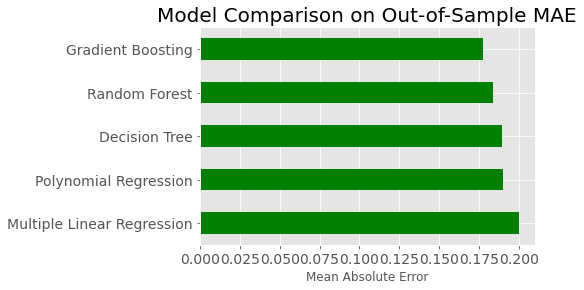

In [115]:
style.use('ggplot')
model_comparison = pd.DataFrame({"model": ["Multiple Linear Regression", "Polynomial Regression","Decision Tree", "Random Forest","Gradient Boosting"],
                                "mae": [0.1997361295454158,0.1899953869120538,0.18942868514056505,0.1836013170735441,0.17719098643012748]})

model_comparison.sort_values("mae", ascending=False).plot(x="model", y="mae", kind="barh",
                                                           color="green", legend=False)
plt.ylabel(""); plt.yticks(size=14); plt.xlabel("Mean Absolute Error"); plt.xticks(size=14)
plt.title("Model Comparison on Out-of-Sample MAE", size=20);



Gradient Boosting is the best out of the 5 models chosen

## Out-of-Sample R-Squared Comparison

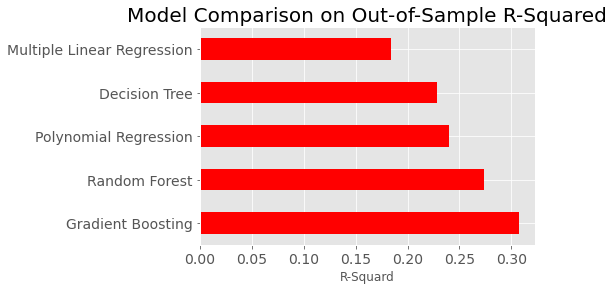

In [116]:
style.use('ggplot')
model_comparison = pd.DataFrame({"model": ["Multiple Linear Regression", "Polynomial Regression","Decision Tree", "Random Forest","Gradient Boosting"],
                                "r2": [0.18453608787488174,0.23951158708306053,0.22876138825470316,0.2735577079928633,0.3069954057626838]})

model_comparison.sort_values("r2", ascending=False).plot(x="model", y="r2", kind="barh",
                                                           color="red", legend=False)
plt.ylabel(""); plt.yticks(size=14); plt.xlabel("R-Squard"); plt.xticks(size=14)
plt.title("Model Comparison on Out-of-Sample R-Squared", size=20);

Gradient Boosting is the best out of the 5 models chosen

### Final Model

In [117]:
final_model = GradientBoostingRegressor(learning_rate=0.01, n_estimators=800,max_depth=11, min_samples_leaf =30, 
               min_samples_split =200, subsample=0.9,random_state=10)
final_model.fit(features_train_scaled,target_train)
Y_pred_final = final_model.predict(features_test_scaled)

Text(0.5, 1.0, 'Variable Importance')

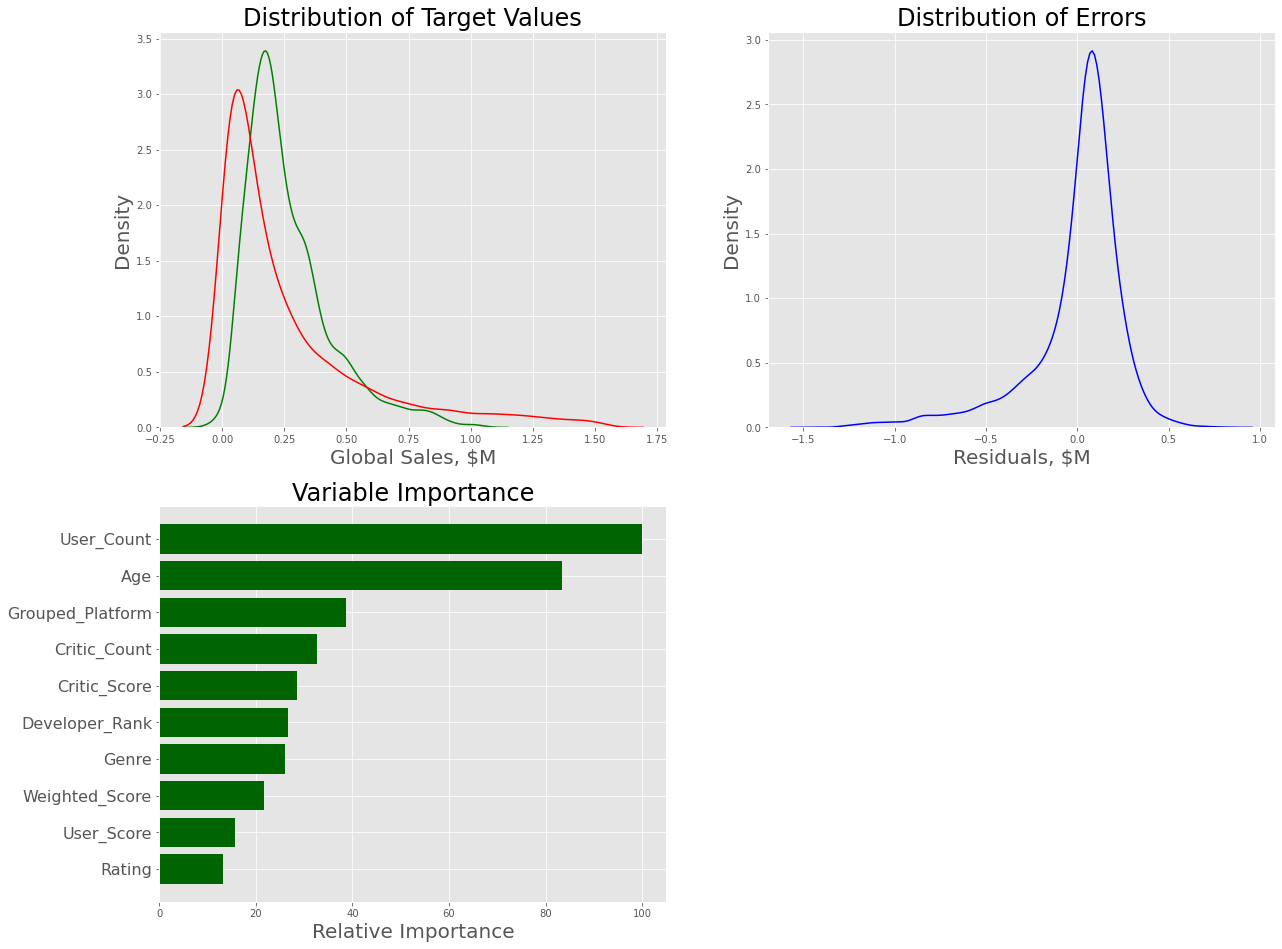

In [118]:
plt.figure(figsize=(20, 16))
plt.title("Video Games - Predicting Global Sales", size=30, weight="bold");

ax=plt.subplot(2, 2, 1)
sb.kdeplot(Y_pred_final, color="green", label="Final Model")
sb.kdeplot(target_test, color="red", label="Test")
plt.xlabel("Global Sales, $M", size=20)
plt.ylabel("Density", size=20)
plt.title("Distribution of Target Values", size=24)


residuals = Y_pred_final - target_test
ax =plt.subplot(2, 2, 2)
sb.kdeplot(residuals, color = "blue", label="Final Model")
plt.xlabel("Residuals, $M", size=20)
plt.ylabel("Density", size=20);
plt.title("Distribution of Errors", size=24)



feature_importance = final_model.feature_importances_
feature_names = features.columns.tolist()
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
ax =plt.subplot(2, 2, 3)
plt.barh(pos, feature_importance[sorted_idx], align='center', color="darkgreen")
plt.yticks(pos, [feature_names[x] for x in sorted_idx], size=16)
plt.xlabel('Relative Importance', size=20)
plt.title('Variable Importance', size=24)

## Bootstrapping

In [119]:
import time
def bootstrap(test_data, test_label, train_label, model_list, metrics_list, n_sample=500, random_state=10):
    np.random.seed(random_state)
    tic = time.time()
    n_metrics = len(metrics_list)
    output_array=np.zeros([n_sample, n_metrics, len(model_list)-1])
    for bs_iter in range(n_sample):
        bs_index = np.random.choice(test_data.index, len(test_data.index), replace=True)
        bs_data = test_data.loc[bs_index]
        bs_label = test_label.loc[bs_index]
        
        bs_predicted1 = model_list[0].predict(bs_data)
        # First case, we want to find CI for a single model (to understand ts robustness)
        if len(model_list) < 2:
            for m_iter in range(n_metrics):
                metric = metrics_list[m_iter]
                output_array[bs_iter, m_iter, 0]=metric(bs_predicted1,bs_label,train_label)
        # if we have more than one model, we are going to calculate differences between the first one and all the others
        else:
            
            bs_predicted1 = model_list[0].predict(bs_data)
            for i in range(1, len(model_list)):
                bs_predicted2 = model_list[i].predict(bs_data)
                for m_iter in range(n_metrics):
                    metric = metrics_list[m_iter]
                    output_array[bs_iter, m_iter, i-1]=metric(bs_predicted2,bs_label,train_label)- metric(bs_predicted1,bs_label,train_label)
    return output_array

In [120]:
bs_output = bootstrap(features_test,target_test,target_train,[gbm4, rf2,dt2],
                                 metrics_list=[OSR2,MAE],
                                n_sample = 5000)

In [123]:
CI_R2 = np.quantile(bs_output[:,0, 0],np.array([0.025,0.975]))
CI_MAE = np.quantile(bs_output[:,1, 0],np.array([0.025,0.975]))

In [124]:
CI_R2

array([0.71435601, 0.83799889])

In [125]:
CI_MAE

array([-0.05599032, -0.05096163])

Comment:
Since two intervals do not contain 0, we can say the difference between three tree-based models are significant.